In [32]:
#keywords
#PERMNO = CRSP Security Identifier 
#GVKEY = S&P Identifier
#IID = S&P Security-level Sub Identifier 

##########################################
# Fama French Factors
# April 2018
# Qingyi (Freda) Song Drechsler
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

###################
# Compustat Block #
###################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1959'
                    """)

comp['datadate']=pd.to_datetime(comp['datadate']) #convert datadate to date fmt
comp['year']=comp['datadate'].dt.year

Enter your WRDS username [Jordan]: jaw220
Enter your password: ····················


WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [3]:
print(comp)

         gvkey   datadate        at    pstkl  txditc   pstkrv      seq  \
0       001000 1961-12-31       NaN    0.000   0.000      NaN      NaN   
1       001000 1962-12-31       NaN    0.000     NaN      NaN      NaN   
2       001000 1963-12-31       NaN    0.000   0.008    0.000    0.553   
3       001000 1964-12-31     1.416    0.000   0.020    0.000    0.607   
4       001000 1965-12-31     2.310    0.000   0.000    0.000    0.491   
...        ...        ...       ...      ...     ...      ...      ...   
516219  335466 2017-12-31       NaN      NaN     NaN      NaN      NaN   
516220  335466 2018-12-31   191.074    0.000   0.000    0.000   54.064   
516221  335466 2019-12-31   201.909    0.000   0.000    0.000   52.128   
516222  339965 2019-01-31   764.288  911.268   0.000  911.268  598.386   
516223  339965 2020-01-31  1012.720  935.389   0.000  935.389  391.717   

           pstk  year  
0           NaN  1961  
1         0.000  1962  
2         0.000  1963  
3         0.000

In [33]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])

comp['txditc']=comp['txditc'].fillna(0) #replacing Nan with 0

print(comp)

         gvkey   datadate        at    pstkl  txditc   pstkrv      seq  \
0       001000 1961-12-31       NaN    0.000   0.000      NaN      NaN   
1       001000 1962-12-31       NaN    0.000   0.000      NaN      NaN   
2       001000 1963-12-31       NaN    0.000   0.008    0.000    0.553   
3       001000 1964-12-31     1.416    0.000   0.020    0.000    0.607   
4       001000 1965-12-31     2.310    0.000   0.000    0.000    0.491   
...        ...        ...       ...      ...     ...      ...      ...   
516219  335466 2017-12-31       NaN      NaN   0.000      NaN      NaN   
516220  335466 2018-12-31   191.074    0.000   0.000    0.000   54.064   
516221  335466 2019-12-31   201.909    0.000   0.000    0.000   52.128   
516222  339965 2019-01-31   764.288  911.268   0.000  911.268  598.386   
516223  339965 2020-01-31  1012.720  935.389   0.000  935.389  391.717   

           pstk  year       ps  
0           NaN  1961    0.000  
1         0.000  1962    0.000  
2         0.

In [34]:
# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]
print(comp.head)

<bound method NDFrame.head of          gvkey   datadate  year      be  count
0       001000 1961-12-31  1961     NaN      0
1       001000 1962-12-31  1962     NaN      1
2       001000 1963-12-31  1963   0.561      2
3       001000 1964-12-31  1964   0.627      3
4       001000 1965-12-31  1965   0.491      4
...        ...        ...   ...     ...    ...
516219  335466 2017-12-31  2017     NaN      2
516220  335466 2018-12-31  2018  54.064      3
516221  335466 2019-12-31  2019  52.128      4
516222  339965 2019-01-31  2019     NaN      0
516223  339965 2020-01-31  2020     NaN      1

[516224 rows x 5 columns]>


In [35]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1959' and '12/31/2017'
                      and b.exchcd between 1 and 3
                      """) 
print(crsp_m.head)

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)
dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1
crsp['me']=crsp['prc'].abs()*crsp['shrout'] # calculate market equity
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

print(crsp.head)

<bound method NDFrame.head of           permno   permco        date  shrcd  exchcd       ret      retx  \
0        10000.0   7952.0  1986-01-31   10.0     3.0       NaN       NaN   
1        10000.0   7952.0  1986-02-28   10.0     3.0 -0.257143 -0.257143   
2        10000.0   7952.0  1986-03-31   10.0     3.0  0.365385  0.365385   
3        10000.0   7952.0  1986-04-30   10.0     3.0 -0.098592 -0.098592   
4        10000.0   7952.0  1986-05-30   10.0     3.0 -0.222656 -0.222656   
...          ...      ...         ...    ...     ...       ...       ...   
3838292  93415.0  53433.0  2014-11-28   14.0     1.0 -0.000714 -0.015357   
3838293  93415.0  53433.0  2014-12-31   14.0     1.0  0.001088  0.001088   
3838294  93415.0  53433.0  2015-01-30   14.0     1.0 -0.076087 -0.076087   
3838295  93415.0  53433.0  2015-02-27   14.0     1.0  0.069216  0.052941   
3838296  93415.0  53433.0  2015-03-31   14.0     1.0 -0.070391 -0.070391   

          shrout        prc  
0         3680.0  -4.375000

In [36]:
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()
# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)
# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()
print(crsp2.head)

<bound method NDFrame.head of          permno  permco       date  shrcd  exchcd       ret      retx  \
1176176   10000    7952 1986-01-31     10       3  0.000000       NaN   
1182378   10000    7952 1986-02-28     10       3 -0.257143 -0.257143   
1188589   10000    7952 1986-03-31     10       3  0.365385  0.365385   
1194810   10000    7952 1986-04-30     10       3 -0.098592 -0.098592   
1201041   10000    7952 1986-05-30     10       3 -0.222656 -0.222656   
...         ...     ...        ...    ...     ...       ...       ...   
3741138   93436   53453 2017-08-31     11       3  0.100257  0.100257   
3746501   93436   53453 2017-09-29     11       3 -0.041585 -0.041585   
3751859   93436   53453 2017-10-31     11       3 -0.028056 -0.028056   
3757218   93436   53453 2017-11-30     11       3 -0.068410 -0.068410   
3762585   93436   53453 2017-12-29     11       3  0.008095  0.008095   

             jdate    retadj            me  
1176176 1986-01-31  0.000000  1.610000e+04  
118

<bound method NDFrame.head of         permno       date      jdate  shrcd  exchcd    retadj            me  \
0        10001 1987-06-30 1987-06-30     11       3  0.051429  5.822125e+03   
1        10001 1988-06-30 1988-06-30     11       3 -0.012039  6.200000e+03   
2        10001 1989-06-30 1989-06-30     11       3  0.017143  7.007000e+03   
3        10001 1990-06-29 1990-06-30     11       3  0.014103  1.005225e+04   
4        10001 1991-06-28 1991-06-30     11       3  0.078481  1.126650e+04   
...        ...        ...        ...    ...     ...       ...           ...   
299678   93436 2013-06-28 2013-06-30     11       3  0.098200  1.303672e+07   
299679   93436 2014-06-30 2014-06-30     11       3  0.155412  2.990859e+07   
299680   93436 2015-06-30 2015-06-30     11       3  0.069617  3.409612e+07   
299681   93436 2016-06-30 2016-06-30     11       3 -0.049053  3.142062e+07   
299682   93436 2017-06-30 2017-06-30     11       3  0.060409  6.033933e+07   

                  wt 

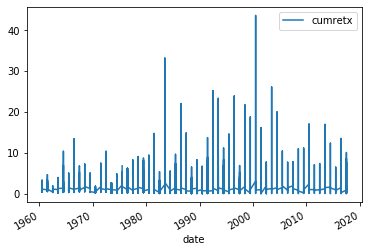

In [37]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

print(crsp_jun.head)
crsp_jun.plot('date', 'cumretx')





In [38]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)

ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])




In [40]:
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & (ccm_jun['count']>1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]
# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])
# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])


In [50]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value


/Users/Jordan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<bound method NDFrame.head of               date  permno  shrcd  exchcd    retadj            me  \
0       1986-01-31   10000     10       3  0.000000  1.610000e+04   
1       1986-02-28   10000     10       3 -0.257143  1.196000e+04   
2       1986-03-31   10000     10       3  0.365385  1.633000e+04   
3       1986-04-30   10000     10       3 -0.098592  1.517200e+04   
4       1986-05-30   10000     10       3 -0.222656  1.179386e+04   
...            ...     ...    ...     ...       ...           ...   
3764384 2017-08-31   93436     11       3  0.100257  5.939508e+07   
3764385 2017-09-29   93436     11       3 -0.041585  5.731060e+07   
3764386 2017-10-31   93436     11       3 -0.028056  5.571925e+07   
3764387 2017-11-30   93436     11       3 -0.068410  5.190749e+07   
3764388 2017-12-29   93436     11       3  0.008095  5.255495e+07   

                   wt   cumretx  ffyear      jdate  
0                 NaN       NaN    1985 1986-01-31  
1                 NaN  0.742857    

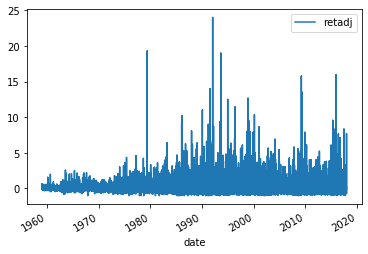

In [57]:
# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

print(crsp3.head)
crsp3.plot('date', 'retadj')

In [60]:
############################
# Form Fama French Factors #
############################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})


print(ff_nfirms)

sbport       date   BH   BL   BM   SH   SL   SM     H    L   HML    B     S  \
0      1962-07-31   15   12   21   14   17   18    29   29    58   48    49   
1      1962-08-31   15   12   21   14   16   18    29   28    57   48    48   
2      1962-09-30   15   12   21   14   17   18    29   29    58   48    49   
3      1962-10-31   15   12   21   14   17   18    29   29    58   48    49   
4      1962-11-30   15   12   21   14   17   18    29   29    58   48    49   
..            ...  ...  ...  ...  ...  ...  ...   ...  ...   ...  ...   ...   
661    2017-08-31  170  383  294  832  588  927  1002  971  1973  847  2347   
662    2017-09-30  169  381  292  828  584  919   997  965  1962  842  2331   
663    2017-10-31  169  379  291  817  581  914   986  960  1946  839  2312   
664    2017-11-30  168  379  288  809  575  909   977  954  1931  835  2293   
665    2017-12-31  168  378  288  799  571  902   967  949  1916  834  2272   

sbport   SMB  TOTAL  
0         97     97  
1      

In [71]:
###################
# Compare With FF #
###################

_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

'''''
sumffSMB = sum(_ff['smb'])
sumffHML = sum(_ff['hml'])

print(_ff)
print(sumffSMB)
print(sumffHML)
'''''

_ffcomp = pd.merge(_ff, ff_factors[['date','WSMB','WHML']], how='inner', on=['date'])
_ffcomp70=_ffcomp[_ffcomp['date']>='01/01/1970']
print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))


           date     smb     hml
0    1926-07-31 -0.0230 -0.0287
1    1926-08-31 -0.0140  0.0419
2    1926-09-30 -0.0132  0.0001
3    1926-10-31  0.0004  0.0051
4    1926-11-30 -0.0020 -0.0035
...         ...     ...     ...
1125 2020-04-30  0.0275 -0.0135
1126 2020-05-31  0.0247 -0.0495
1127 2020-06-30  0.0270 -0.0222
1128 2020-07-31 -0.0222 -0.0132
1129 2020-08-31 -0.0010 -0.0310

[1130 rows x 3 columns]
2.134800000000003
3.6671999999999985
(0.9959270916527514, 0.0)
(0.9826575028124656, 0.0)
